In [31]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import Datasets.ModelData as md
from session import *
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
from LR_Schedule.cos_anneal import CosAnneal
import matplotlib.pyplot as plt

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
idtohand = {0: "Nothing in hand; not a recognized poker hand",
            1: "One pair; one pair of equal ranks within five cards",
            2: "Two pairs; two pairs of equal ranks within five cards",
            3: "Three of a kind; three equal ranks within five cards",
            4: "Straight; five cards, sequentially ranked with no gaps",
            5: "Flush; five cards with the same suit",
            6: "Full house; pair + different rank three of a kind",
            7: "Four of a kind; four equal ranks within five cards",
            8: "Straight flush; straight + flush",
            9: "Royal flush; {Ace, King, Queen, Jack, Ten} + flush" }

num_classes = 10

idtosuit = {0: "Hearts", 1: "Spades", 2: "Diamonds", 3: "Clubs"}
idtorank = {0: "Ace", 
            1: "2", 
            2: "3", 
            3: "4", 
            4: "5", 
            5: "6", 
            6: "7", 
            7: "8", 
            8: "9", 
            9: "10", 
            10: "Jack", 
            11: "Queen", 
            12: "King"}

In [34]:
class PokerHandDataset(Dataset):
    def __init__(self, file, percentage=1):
        self.hands, self.labels = self.parse_csv(file, percentage)
       
    @staticmethod
    def parse_csv(file, percentage=1):
        df = pd.read_csv(file, header=None)
        xs = df[df.columns[0:10]]
        ys = df[df.columns[-1]]
        
        labels = np.array([label for label in ys])
        hands = np.array([np.array(hand).reshape((5,2)) - 1 for hand in xs.values])
        
        if percentage < 1:
            idxs = np.random.choice(len(xs), int(len(xs) * percentage), replace=False)
            hands = hands[idxs]
            labels = labels[idxs]
            
        return hands, ys
        
    @staticmethod
    def make_tensor(hand):
        hand_tensor = torch.zeros((4,13))
        for card in hand:       
            hand_tensor[card[0], card[1]] = 1
        return hand_tensor.unsqueeze(0)
    
    @staticmethod
    def make_one_hot(label):
        tensor = torch.zeros(10)
        tensor[label] = 1
        return tensor
    
    def __len__(self): return len(self.hands)

    def __getitem__(self, i):
        hand, label = self.hands[i], self.labels[i]
        x, y = self.make_tensor(hand), self.make_one_hot(label)
        return x, y

In [35]:
data_path = Path("./Datasets/PokerHands")
train_dataset = PokerHandDataset(data_path/'training.csv')
test_dataset = PokerHandDataset(data_path/'testing.csv', percentage=.05)

In [36]:
data = md.ModelData({'train': train_dataset, 'test': test_dataset}, 64)

In [70]:
class Network(nn.Module):
    def __init__(self):
        super().__init__();
        self.conv1 = nn.Conv2d(1, 64, (4,1))       
        self.conv2 = nn.Conv2d(1, 64, (1,13))
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=.9)
        self.fc1 = nn.Linear(64*4 + 64*13, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        x_1 = self.conv1(x)
        x_2 = self.conv2(x)
        x = torch.cat([x_1.view(x_1.size(0), -1), x_2.view(x_2.size(0), -1)], dim=1)
        x = self.drop(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = Network()

In [71]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, label):
        weight = self.get_weight(pred, label)
        return F.binary_cross_entropy_with_logits(pred, label, weight)
    
    def get_weight(self, x, t):
        alpha, gamma = 0.25, 2
        p = x
        pt = p * t + (1-p) * (1-t)
        w = alpha * t + (1-alpha) * (1-t)
        return w * (1-pt).pow(gamma)

In [72]:
class PokerHandAccuracy(_AccuracyMeter):
    def __init__(self):
        self.reset()
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]

    def reset(self):
        self.num_correct = 0
        self.count = 0
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]
        
    def accuracy(self): 
        return self.num_correct / self.count

    def update(self, actn, label, log=False):   
        outputs = torch.sigmoid(actn)
        # if log: print("Actn : ", outputs)
        vals, preds = torch.max(outputs, 1)
        # preds = preds + 1
        if log: print("Max  :", preds)
        # bgs = vals < .7
        # if log: print("BGS  : ", bgs)
        # preds[bgs] = 0
        if log: print("Preds: ", preds)
        _, gt = torch.max(label, 1)     
        if log: print("GT   : ", gt)
        self.num_correct += torch.sum(preds == gt).item()
        if log: print("Num Correct: ", self.num_correct)
        self.count += label.shape[0]
        
        for lab, pred in zip(gt, preds):
            self.confusion[lab][pred] += 1
            
    def plot_confusion_matrix(self,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        cm = np.array(self.confusion)
        fig, ax = plt.subplots(figsize=(12,12))
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar(img, ax=ax)
        ax.set_title(title)
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

In [73]:
criterion = FocalLoss(num_classes)
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, 1e-2)

In [74]:
x, y = next(iter(data['train']))
actn = sess.forward(x)
accuracy = PokerHandAccuracy()

In [75]:
accuracy.update(actn, y, log=True)

Max  : tensor([5, 7, 3, 3, 2, 8, 4, 6, 3, 8, 9, 3, 5, 0, 0, 0, 5, 3, 2, 4, 8, 0, 8, 8,
        1, 3, 5, 7, 9, 8, 8, 4, 3, 0, 4, 4, 4, 4, 8, 5, 5, 8, 5, 0, 8, 5, 0, 8,
        8, 0, 0, 5, 0, 5, 5, 0, 2, 7, 5, 2, 8, 3, 4, 3])
Preds:  tensor([5, 7, 3, 3, 2, 8, 4, 6, 3, 8, 9, 3, 5, 0, 0, 0, 5, 3, 2, 4, 8, 0, 8, 8,
        1, 3, 5, 7, 9, 8, 8, 4, 3, 0, 4, 4, 4, 4, 8, 5, 5, 8, 5, 0, 8, 5, 0, 8,
        8, 0, 0, 5, 0, 5, 5, 0, 2, 7, 5, 2, 8, 3, 4, 3])
GT   :  tensor([0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0])
Num Correct:  6


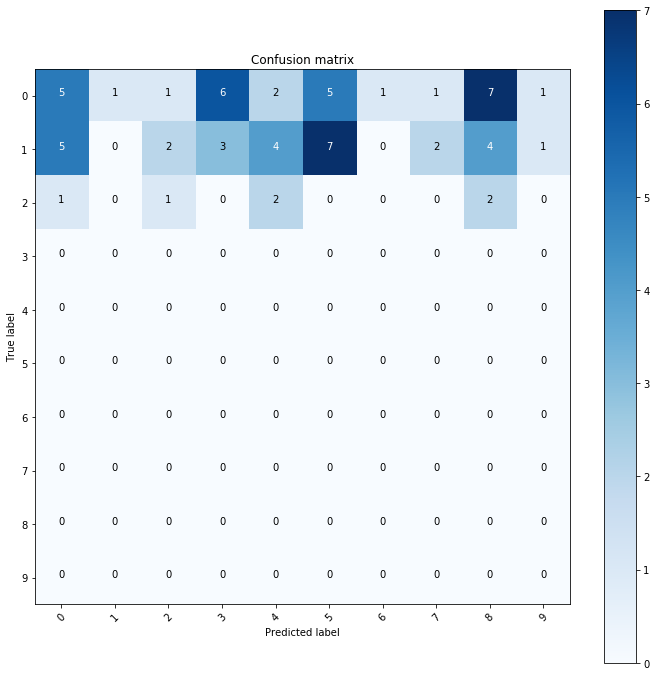

In [76]:
accuracy.plot_confusion_matrix()

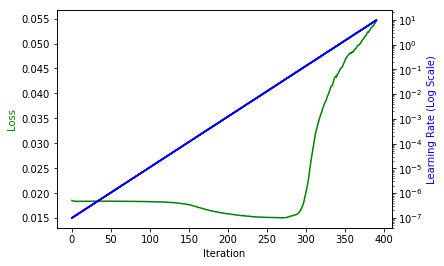

In [77]:
lr_find(sess, data['train'], start_lr=1e-7)

In [78]:
sess.set_lr(1e-2)

In [79]:
accuracy = PokerHandAccuracy()
validator = Validator(data['test'], accuracy)
lr_schedule = CosAnneal(len(data['train']), lr_min=1e-5, T_mult=2)
schedule = TrainingSchedule(data['train'], [lr_schedule, validator])

In [80]:
sess.train(schedule, 3)

Training Loss: 0.012628  Validaton Loss: 0.015633 Validation Accuracy: 0.469080


Training Loss: 0.010573  Validaton Loss: 0.022180 Validation Accuracy: 0.463020


Training Loss: 0.009669  Validaton Loss: 0.023911 Validation Accuracy: 0.463020



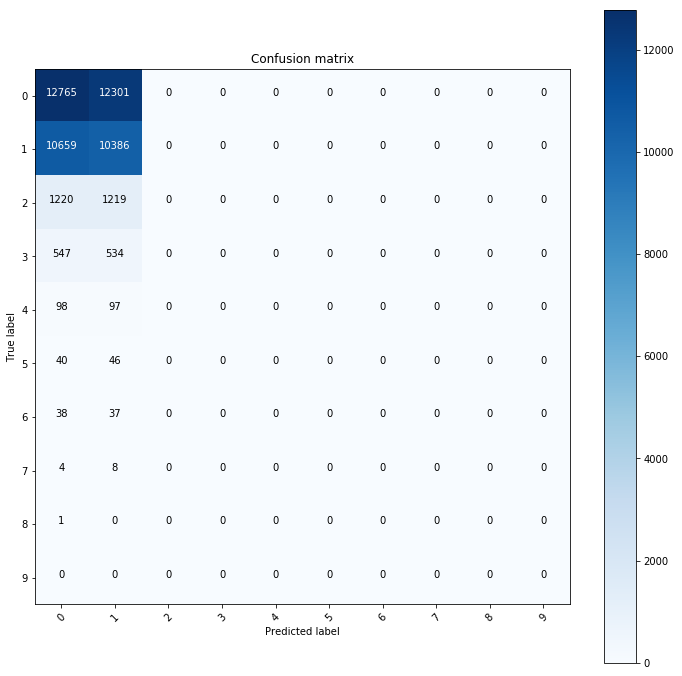

In [81]:
accuracy.plot_confusion_matrix()

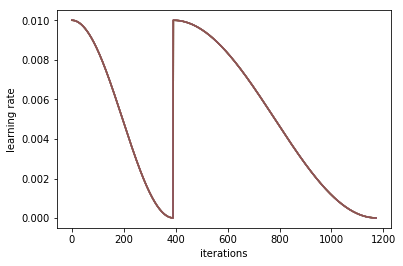

In [65]:
lr_schedule.plot()

In [66]:
sess.save("PokerHand-99.6")

In [67]:
t_accuracy = PokerHandAccuracy()
t_validator = Validator(data['train'], t_accuracy)

In [68]:
t_validator.on_epoch_end(sess, LossMeter())

Training Loss: 0.000000  Validaton Loss: 0.001169 Validation Accuracy: 0.984366


In [69]:
t_accuracy.confusion

[[12493, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 10599, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1203, 3, 0, 0, 0, 0, 0, 0],
 [0, 0, 189, 324, 0, 0, 0, 0, 0, 0],
 [93, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [54, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 34, 2, 0, 0, 0, 0, 0, 0],
 [0, 0, 2, 4, 0, 0, 0, 0, 0, 0],
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
len(data['train'])

In [ ]:
len(data['test'])